In [1]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import skew

In [2]:
def simulate(A=1, B=1, C=10, D=1000):
  W = np.random.normal(0,1,D)
  X = W+np.random.normal(0,B,D)
  Y = A*X-W+np.random.normal(0,C,D)
  return Y, X, W

In [3]:
nums = 1000
count_significant = 0

for _ in range(nums):
    Y, X, W = simulate()

    predictors = np.column_stack((X, W))
    predictors = sm.add_constant(predictors)

    model = sm.OLS(Y, predictors).fit()

    t_X = model.tvalues[1]

    if abs(t_X) > 1.96:
        count_significant += 1

power = count_significant / nums

power

0.878

In [4]:
np.random.seed(42)
nums = 10000
coefs_X = []

for _ in range(nums):
    Y, X, W = simulate()

    predictors = np.column_stack((X, W))
    predictors = sm.add_constant(predictors)

    model = sm.OLS(Y, predictors).fit()

    coef_X = model.params[1]
    coefs_X.append(coef_X)

skew_value = skew(coefs_X)
skew_value

np.float64(-0.01512426443969821)

In [5]:
B_values = [0.2, 0.6, 1.0, 1.8, 2.5, 5.4]

np.random.seed(42)
nums = 1000
result = {}

for B in B_values:
    count_significant = 0

    for _ in range(nums):
        Y, X, W = simulate(A=1, B=B, C=10, D=1000)
        predictors = np.column_stack((X, W))
        predictors = sm.add_constant(predictors)

        model = sm.OLS(Y, predictors).fit()
        t_X = model.tvalues[1]

        if abs(t_X) > 1.96:
            count_significant += 1
        
    power = count_significant / nums
    result[B] = power

for B, power in result.items():
    print(f"B = {B}: Estimated power = {power}")

B = 0.2: Estimated power = 0.115
B = 0.6: Estimated power = 0.469
B = 1.0: Estimated power = 0.899
B = 1.8: Estimated power = 0.999
B = 2.5: Estimated power = 1.0
B = 5.4: Estimated power = 1.0


In [6]:
A_values = [0.5, 1.0, 2.0, 4.0]
np.random.seed(42)
nums = 1000
result = {}
for A in A_values:
    count_significant = 0
    for _ in range(nums):
        Y, X, W = simulate(A=A, B=1, C=10, D=100)
        predictors = np.column_stack((X, W))
        predictors = sm.add_constant(predictors)

        model = sm.OLS(Y, predictors).fit()
        t_X = model.tvalues[1]

        if abs(t_X) > 1.96:
            count_significant += 1
    power = count_significant / nums
    result[A] = power
    
for A, power in result.items():
    print(f"A = {A}: Estimated power = {power}")

A = 0.5: Estimated power = 0.083
A = 1.0: Estimated power = 0.162
A = 2.0: Estimated power = 0.513
A = 4.0: Estimated power = 0.977


In [9]:
# reflection q1
import statsmodels.api as sm
import matplotlib.pyplot as plt

np.random.seed(42)
n_sim = 1000
n = 100

beta_true = 2.0
empirical_betas = []

for _ in range(n_sim):
    X = np.random.uniform(0, 5, n)
    # Heteroskedastic error
    error = np.random.normal(0, 1 + 0.5 * X, n)
    y = beta_true * X + error

    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()
    empirical_betas.append(model.params[1])

# emiprical standard deviation of beta
emp_std = np.std(empirical_betas)
print(f"Emmpirical standard deviation of coefficients: {emp_std:.4f}")

# OLS standrad error form a single run
X = np.random.uniform(0, 5, n)
error = np.random.normal(0, 1 + 0.5 * X, n)
y = beta_true * X + error
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()
ols_std = model.bse[1]
print(f"OLS standard error from statsmodels:{ols_std:.4f}")


Emmpirical standard deviation of coefficients: 0.1705
OLS standard error from statsmodels:0.1654


Empirical standard deviation(true SD): 0.2038
OLS standard error:0.1776
Bootstrap standard error(naive): 0.1807


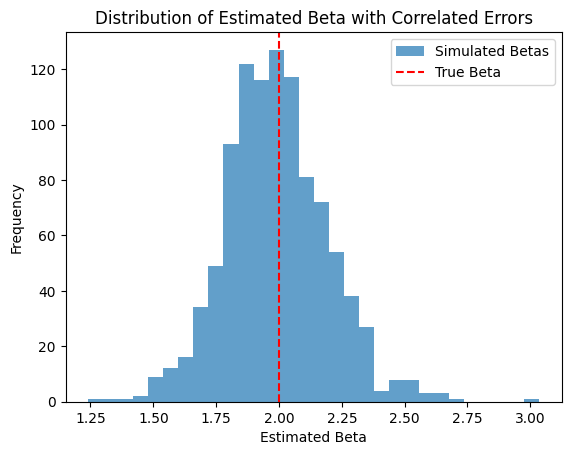

In [11]:
#reflection 2
np.random.seed(0)
n_sim = 1000
n = 100
rho = 0.9

beta_true = 2.0
empirical_betas = []

def generate_errors(n, rho):
    errors = np.zeros(n)
    eta = np.random.normal(0, 1, n)
    for t in range(1, n):
        errors[t] = rho * errors[t-1] + eta[t]
    return errors

for _ in range(n_sim):
    X = np.random.normal(0, 1, n)
    errors = generate_errors(n, rho)
    y = beta_true * X + errors
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()
    empirical_betas.append(model.params[1])

emp_std = np.std(empirical_betas)
print(f"Empirical standard deviation(true SD): {emp_std:.4f}")

#single run get OLS and bootstrap SE
X = np.random.normal(0, 1, n)
errors = generate_errors(n, rho)
y = beta_true * X + errors
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()
ols_se = model.bse[1]
print(f"OLS standard error:{ols_se:.4f}")

#bootstrap standard error
n_boot = 500
boot_betas = []
residuals = model.resid
for _ in range(n_boot):
    resample_idx = np.random.choice(np.arange(n), n, replace = True)
    y_boot = model.fittedvalues + residuals[resample_idx]
    boot_model = sm.OLS(y_boot, X_sm).fit()
    boot_betas.append(boot_model.params[1])
boot_se = np.std(boot_betas)
print(f"Bootstrap standard error(naive): {boot_se:.4f}")

plt.hist(empirical_betas, bins=30, alpha=0.7, label="Simulated Betas")
plt.axvline(beta_true, color='red', linestyle = "--", label="True Beta")
plt.title("Distribution of Estimated Beta with Correlated Errors")
plt.xlabel("Estimated Beta")
plt.ylabel("Frequency")
plt.legend()
plt.show()